# Purpose of this notebook

Hey John, thanks for your help. I appreciate you taking your time.

In this notebook, I'll try my best to demonstrate the issue/error that I've experienced while using the haMSM pipeline to get π, h, and v. The thing is, we weren't able to precisely narrow down where the supposed indexing error is. However, we have some 

The clues that we have so far are: 

- We haven't been able to observe variance minimization using the haMSM pipeline at different iteration length (that we're using to estimate h and v), number of clusters per strata, and size of the phase space (we've used both the original 10500 state model and a truncated 100 state model).
- When we look at the haMSM π, h, and v and compare it to the 'exact mapped' results (what the haMSM π, h, and v would look like if we had inifinite sampling, more on this later), the agreement between the two don't quite match up. Specifically, when you compare the two qualitatively you see limiting behavior (difference between the two becomes smaller as we increase sampling), but when you plot a scatter plot, there are noticable off-diagonal elements.
- For the haMSM runs with lot of data (2000, 5000 iterations), we see pretty flat / converged flux trace, so we suspect that the trajectory that we're training the haMSM with has sufficient data.
- You can estimate the π, h, and v pretty well using MSM and a long synD trajectory using a similar procedure, so this makes us think that the lack of training data in haMSM is not the issue. 

Dan and I suspect that it must have something to do with the indexing within the strata, but pinpointing it has been less straightforward. I'm hoping that your input/feedback will help us with resolving this issue. 

# Load packages

In [22]:
import ray
import time
from msm_we import modelWE
import numpy as np
import pickle
import sys
import deeptime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from msm_we import optimization as mo
from deeptime.markov.msm import MarkovStateModel, MaximumLikelihoodMSM
from mr_toolkit.clustering import StratifiedClusters

from exact_mapped_from_hamsm_functions import processCoordinates, CG_matrix, partition_in_bin, \
                                              get_exact_mapped_microstate_to_cluster_assignment

# Load exact synD data

In [23]:
# Transition matrix, microstate index vs RMSD value, pi, h, and v
tmatrix_FG = np.loadtxt('reference/'+'T_CG_with_BC_n_state_100.txt')
state_to_pcoord = np.loadtxt('reference/'+'state_to_pcoord_CG_n_state_100.txt')
pi_exact = np.loadtxt('reference/'+'pi_CG_n_state_100.txt')
h_exact = np.loadtxt('reference/'+'h_CG_n_state_100.txt')
v_exact = np.loadtxt('reference/'+'v_CG_n_state_100.txt')

# Number of microstates
n_microstate = len(state_to_pcoord)

# Dictionary of atomic configuration for each microstate
with open(path+'reference/'+'coord_map_n_state_100.pkl','rb') as inf:
    coord_map = pickle.load(inf)

Here I'm using a more manageable 100-state synD model, still of trp-cage, that I get by CG-ing the 10500-state model uniformly in index space using this equation 
$$
T_{CG,mn} = \sum_{i∈m}\sum_{j∈n}(\omega_{i} T_{FG,ij}) / \sum_{i∈m}(\omega_{i})
$$
where $T_{CG,mn}$ is the mth row nth column element of the CG transition matrix, $T_{FG,ij}$ is the ith row jth column element of the FG transition matrix, and $\omega_{i}$ is the steady state distribution value for the FG state (microstate) i.

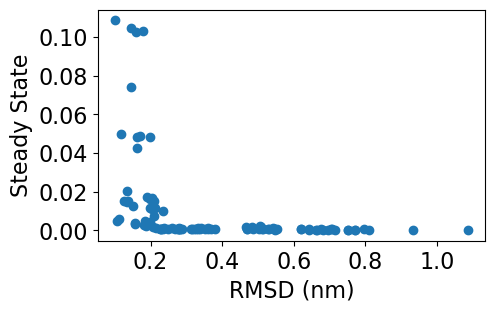

In [24]:
plt.figure(figsize=(5,3))

plt.scatter(state_to_pcoord[:,1],pi_exact)

font = 16
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('RMSD (nm)',size=font);
plt.ylabel('Steady State',size=font);

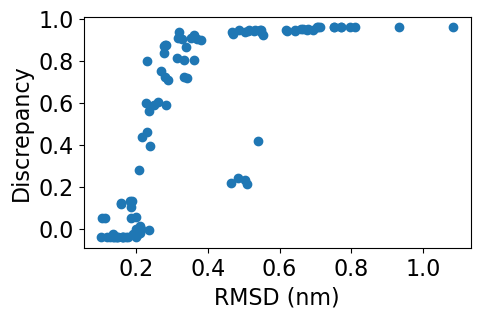

In [25]:
plt.figure(figsize=(5,3))

plt.scatter(state_to_pcoord[:,1],h_exact)

font = 16
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('RMSD (nm)',size=font);
plt.ylabel('Discrepancy',size=font);

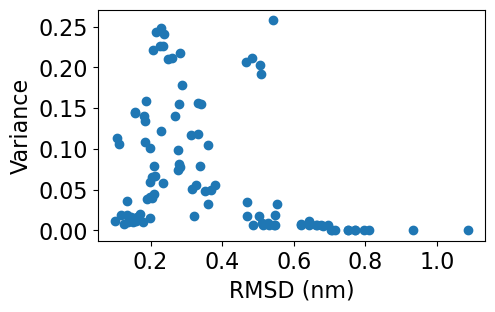

In [26]:
plt.figure(figsize=(5,3))

plt.scatter(state_to_pcoord[:,1],v_exact)

font = 16
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('RMSD (nm)',size=font);
plt.ylabel('Variance',size=font);

# Load haMSM data

The haMSM models that I'm analyzing here were built with synD + WE trajectory with 13 bins ```[0.0, 0.103, 0.1467928 , 0.17756054, 0.19955947, 0.21659479, 0.26090395, 0.28767538, 0.34118432, 0.46846998, 0.52846795, 0.61953086, 0.7,  np.inf]``` and 8 walkers/bin. 

In [27]:
# Here are the haMSM parameter combinations that I have tried:
haMSM_params = [
    'n_cluster_1_n_iter_100',
    'n_cluster_1_n_iter_2000',
    'n_cluster_5_n_iter_100',
    'n_cluster_5_n_iter_2000',
    'n_cluster_10_n_iter_100',
    'n_cluster_10_n_iter_2000',
    'n_cluster_10_n_iter_5000'
]

# Path to haMSM data
path = '../hamsm_models/'

# Load the haMSM models into dictionary
models = {}
for param in haMSM_params:
    with open(path+param+'.pkl', 'rb') as pkl_file:
        models[param] = pickle.load(pkl_file)
    models[param].processCoordinates = processCoordinates

/Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceModel from version 0.4.3 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceKoopmanModel from version 0.4.3 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator VAMP from version 0.4.3 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator

In [28]:
# Calculate π, h, and v for each haMSM model 
haMSM_functions = {}

for param in haMSM_params:
    # Define dictionary for each parameter combination 
    haMSM_functions[param] = {}

    # Get RMSD
    haMSM_functions[param]['RMSD'] = models[param].targetRMSD_centers
    
    # Get pi
    haMSM_functions[param]['pi'] = models[param].pSS

    # Get h and v
    h_hamsm, v_hamsm = mo.solve_discrepancy(tmatrix = models[param].Tmatrix,
                                            pi = models[param].pSS,
                                            B = models[param].indTargets)
    haMSM_functions[param]['h'] = h_hamsm
    haMSM_functions[param]['v'] = v_hamsm

[09/23/23 16:47:32] INFO     Computing pi matrix                                                 ]8;id=224886;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=643477;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

                    INFO     Computing pi matrix                                                 ]8;id=359882;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=457028;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

                    INFO     Computing pi matrix                                                 ]8;id=787898;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=729781;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

                    INFO     Computing pi matrix                                                 ]8;id=147217;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=776835;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

                    INFO     Computing pi matrix                                                 ]8;id=459023;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=491541;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

                    INFO     Computing pi matrix                                                 ]8;id=550877;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=459676;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

                    INFO     Computing pi matrix                                                 ]8;id=455943;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=735604;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

# Flux profile for different parameter combinations

Here are the flux profiles for different parameter sets in RMSD space. 

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=778303;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=798464;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=780232;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=895643;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_0, generating ]8;id=263978;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=31523;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=752389;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=356918;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=980079;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=272041;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_1, generating ]8;id=594469;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=646948;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=382967;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=810986;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=205490;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=230388;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=313667;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=949264;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#415\415]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=941823;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=957872;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=390280;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=838822;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_0, generating ]8;id=932641;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=336476;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=816574;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=839777;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=593626;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=115669;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_1, generating ]8;id=696106;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=556630;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=730655;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=178206;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=674747;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=594177;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=38012;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=201865;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#415\415]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

[09/23/23 16:47:33] WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=125834;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=812563;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=78507;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=617418;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_0, generating ]8;id=496436;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=833438;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=108730;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=514504;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=193615;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=20164;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_1, generating ]8;id=284016;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=590868;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=595866;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=594708;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=528518;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=80341;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=220377;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=866593;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#415\415]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=92295;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=543523;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=694419;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=130300;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_0, generating ]8;id=507043;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=920225;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=81365;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=424702;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=31907;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=398246;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_1, generating ]8;id=681259;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=719732;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=52346;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=980519;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=852432;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=722858;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=542930;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=348467;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#415\415]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=113167;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=865407;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=339168;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=145904;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_0, generating ]8;id=762140;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=235881;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=604094;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=598958;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=502233;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=393834;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_1, generating ]8;id=696095;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=253429;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=209250;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=503840;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=261431;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=747055;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=349784;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=559903;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#415\415]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=401597;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=893077;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

[09/23/23 16:47:34] WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=680169;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=772326;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_0, generating ]8;id=426159;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=4260;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=270437;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=154946;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=985414;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=21859;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_1, generating ]8;id=724141;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=587957;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=229815;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=279712;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=453567;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=708248;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=687340;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=228670;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#415\415]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=393528;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=734419;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=625600;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=100901;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_0, generating ]8;id=770483;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=12330;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=325932;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=94119;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=667449;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=880196;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    INFO     Fluxes have not yet been generated for validation_model_1, generating ]8;id=894421;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=955799;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#311\311]8;;\
                             now.                                                                                  

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=184639;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=896434;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#402\402]8;;\
                             currently built in to the code.                                                       

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=151778;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=184516;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_analysis.py#461\461]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=852558;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=999879;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/_hamsm/_plotting.py#415\415]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

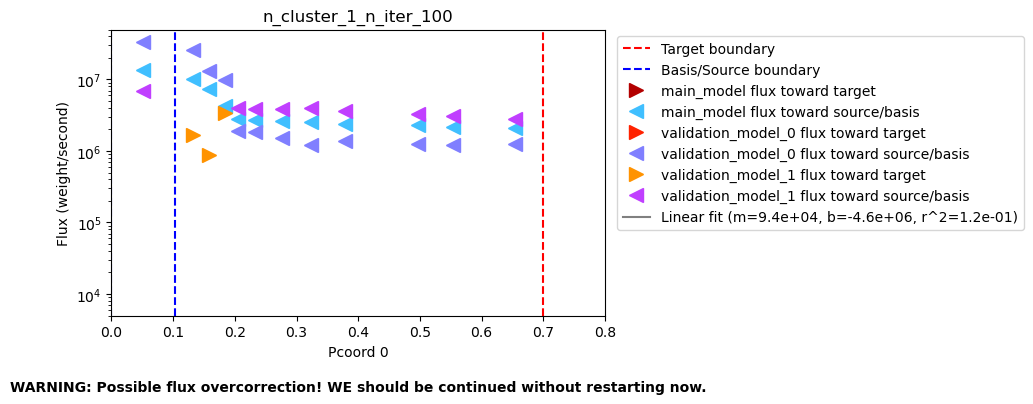

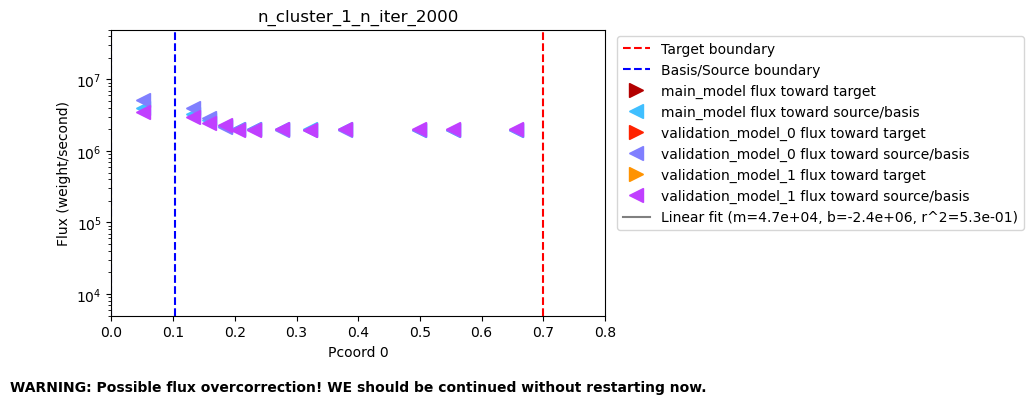

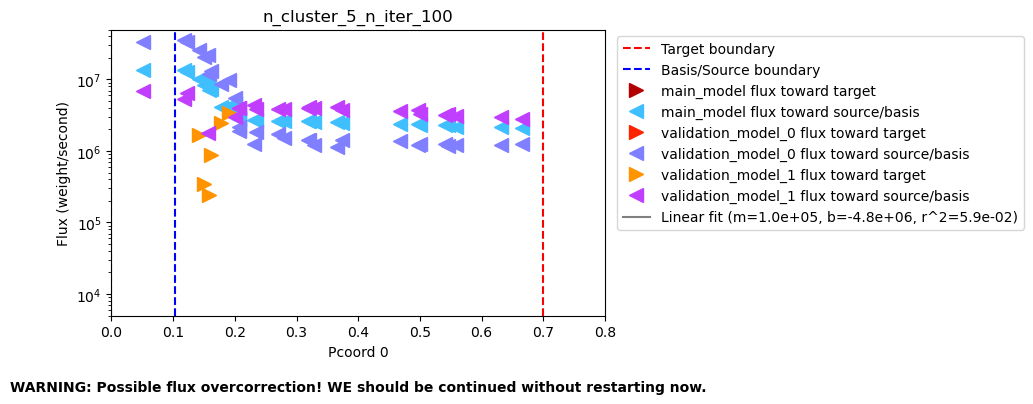

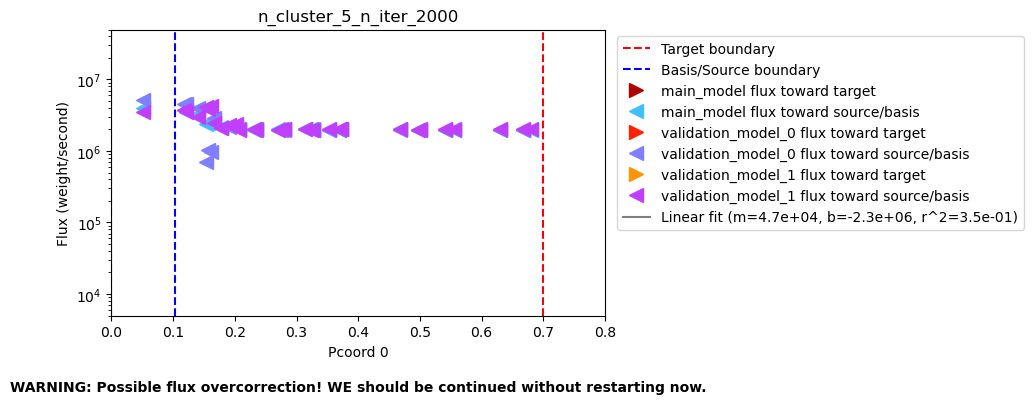

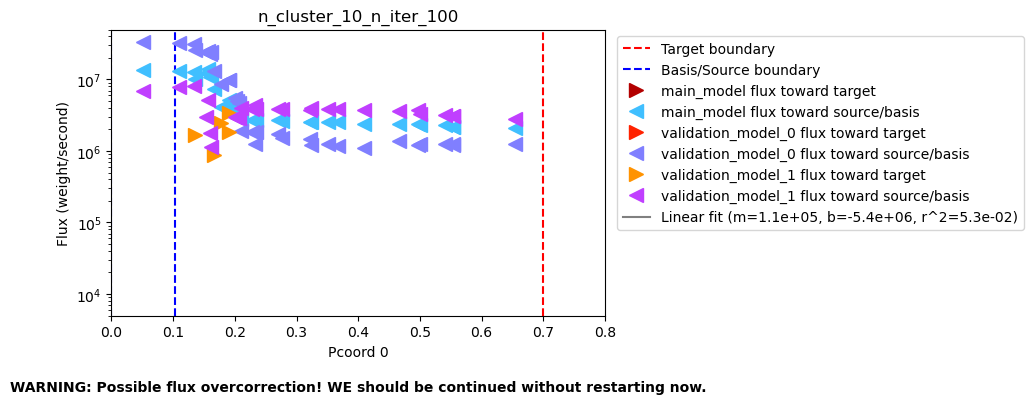

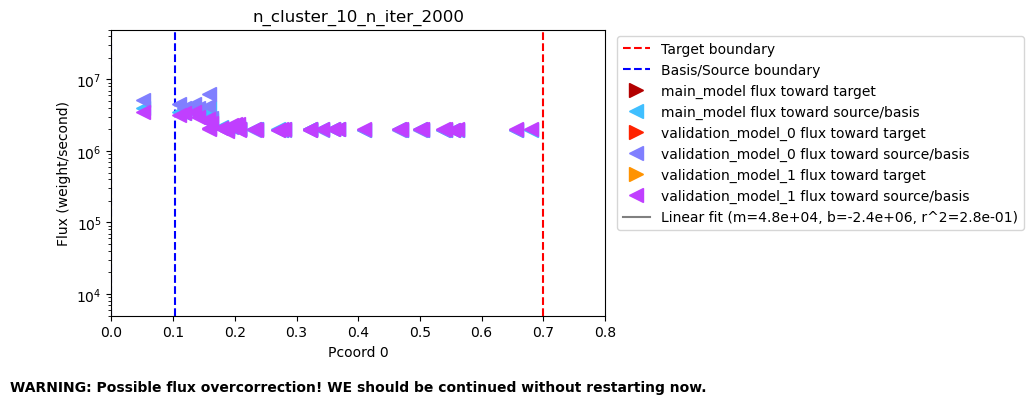

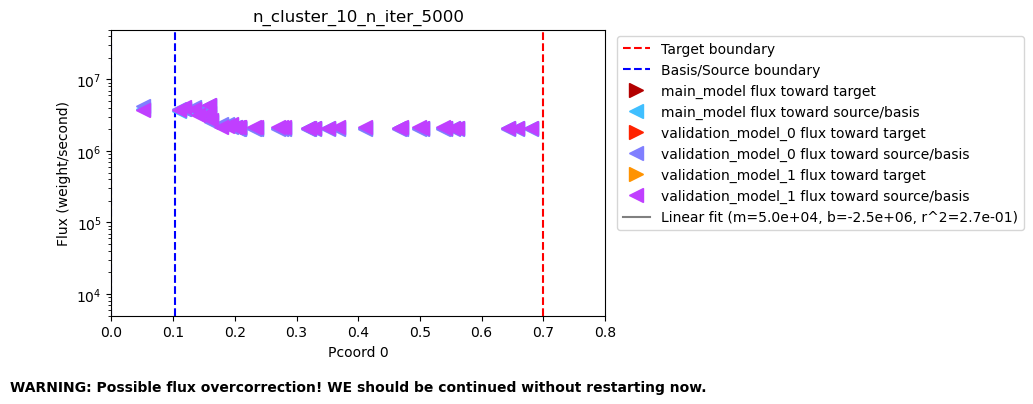

In [29]:
for param in haMSM_params:
    models[param].get_flux()
    ax = models[param].plot_flux();
    ax.set_xlim([0,0.8])
    ax.set_ylim([5e3, 5e7])
    ax.set_title(param)

We see that for the 2000 iteration runs, the traces of different validation models agree with each other pretty well and are pretty flat, and for the 5000 iteration run, the different traces are indistinguishable from each other and flat as well.

I actually have not looked at these flux traces carefully when looking at the haMSM models, but I assume that this shows that the models with 2000 and more iterations are converged in terms of flux. 

One thing to check from these models is the ```JtargetSS```. Let's calculate the reference flux first.

In [30]:
# Define basis and target microstate indices 
# Consistent with how it's defined in the WE run 
basis = np.argmin(state_to_pcoord[:,1]) # 7
target = np.where(state_to_pcoord[:,1]>0.7)[0] # All microstates with RMSD greater than 0.7

# Calculate flux
# Note that this is T WITH boundary condition
msm = deeptime.markov.msm.MarkovStateModel(tmatrix_FG)
ref_flux = 1/msm.mfpt(basis,target)

print(f"Reference flux from the synD transition matrix is: {ref_flux:.4e}")

Reference flux from the synD transition matrix is: 2.2005e-03


In [31]:
for param in haMSM_params:
    haMSM_flux = models[param].JtargetSS*1e-9
    print(f'For haMSM run {param}, the estimated flux is {haMSM_flux:.4e}, {haMSM_flux/ref_flux*100:.2f}% of the reference flux')

For haMSM run n_cluster_1_n_iter_100, the estimated flux is 2.3510e-03, 106.84% of the reference flux
For haMSM run n_cluster_1_n_iter_2000, the estimated flux is 1.9913e-03, 90.49% of the reference flux
For haMSM run n_cluster_5_n_iter_100, the estimated flux is 2.5353e-03, 115.21% of the reference flux
For haMSM run n_cluster_5_n_iter_2000, the estimated flux is 2.0059e-03, 91.16% of the reference flux
For haMSM run n_cluster_10_n_iter_100, the estimated flux is 2.6217e-03, 119.14% of the reference flux
For haMSM run n_cluster_10_n_iter_2000, the estimated flux is 2.0469e-03, 93.02% of the reference flux
For haMSM run n_cluster_10_n_iter_5000, the estimated flux is 2.0576e-03, 93.51% of the reference flux


We see that for the 100 iterations some of the estimated fluxes are off more than 10% of the reference value, but for the 2000 and 5000 iteration ones the agreement is within 10% and pretty good. 

# Exact mapped functions

One question that we put a lot of thought into is "what should the haMSM functions be compared against?" Easy answer would be to simply compare it against the original synD functions, but that wasn't so insightful as the synD (FG) and haMSM (CG) functions are in different resolutions. 

Here is a procedure to get a CG version of the exact functions, namely **exact mapped** functions, at the same resolution as the haMSM functions that we came up with that makes the most sense:

- Using the information from synD model, calculate the RMSD and other CV (VAMP here) values for every microstate. Use ```reduceCoordinates``` function in the haMSM model to get the VAMP values. 
- Apply stratified clustering to these RMSD and VAMP values to get mapping from microstate to haMSM cluster and the RMSD of the clusters. Here, in doing the stratified clustering, each microstate is weighed by its FG π value. I'm also using the same strata boundary and number of actual clusters in strata as what you got in haMSM. 
- Once you have the mapping, you can calculate the CG transition matrix and the exact mapped steady state using this equation $T_{CG,mn} = \sum_{i∈m}\sum_{j∈n}(\omega_{i} T_{FG,ij}) / \sum_{i∈m}(\omega_{i})$. Using the RMSD values of the clusters, you can define the source/sink states (same definition as what haMSM was using) and calculate discrepancy and variance. 

Few comments on this: 

- I implemented my own stratified clustering (```get_exact_mapped_microstate_to_cluster_assignment```) for few reasons: 
    - Stratified clustering in ```mr_toolkit``` doesn't encorporate weight when doing K-means. But for this case, I needed to weigh each microstate according to their weights because we're CG-ing using underlying synD information.
    - The number of clusters in each strata from haMSM is different from what you initially specify (from cleaning procedure) and different from strata to strata. There was no way to enforce these different number of clusters/strata in the ```mr_toolkit``` stratified clustering.
- In my implementation, I ordered the cluster index with respect to increasing RMSD value.
- If you calculate exact mapped functions this way, the RMSD and VAMP values for the coordinates will be different from what you get from haMSM, but we see that generally they agree with one another and the scatter plot of RMSD values are pretty linear. i'll show this later in the notebook  

In [32]:
# Define bin boundaries and number of bins
bin_boundaries = [0.        , 0.103     , 0.1467928 , 0.17756054, 0.19955947,
                  0.21659479, 0.26090395, 0.28767538, 0.34118432, 0.46846998,
                  0.52846795, 0.61953086, 0.7,  np.inf]
n_bin = len(bin_boundaries)-1

In [33]:
# Loop over the haMSM_params list to calculate exact mapped functions
exact_mapped_functions = {}

for param in haMSM_params:
    # Define total number of clusters (different for each haMSM parameter combinations) 
    n_cluster = len(models[param].targetRMSD_centers)

    # VAMP's dimensionality  
    n_vamp = np.shape(models[param].reduceCoordinates(coord_map[0]))[1]
    
    # RMSD and VAMP of all microstates
    pcoord_and_dimreduce = np.zeros((len(state_to_pcoord), n_vamp + 1))
    for i in range(len(pcoord_and_dimreduce)):
        pcoord_and_dimreduce[i] = np.concatenate(([state_to_pcoord[i][1]],
                                                  models[param].reduceCoordinates(coord_map[i])[0]))

    # Microstates and cluster centers in bins
    microstate_value_in_bin, microstate_index_in_bin = partition_in_bin(bin_boundaries, state_to_pcoord[:,1])
    cluster_value_in_bin, cluster_index_in_bin = partition_in_bin(bin_boundaries, models[param].targetRMSD_centers)

    # Calculate microstate_to_cluster_assignment and RMSD of cluster centers
    microstate_to_cluster_assignment_list, cluster_centers_exact_mapped = \
    get_exact_mapped_microstate_to_cluster_assignment(pcoord_and_dimreduce, 
                                                      pi_exact, 
                                                      microstate_index_in_bin, 
                                                      cluster_index_in_bin)

    # Calulate corresponding CG transition matrix
    tmatrix_CG = CG_matrix(n_cluster,microstate_to_cluster_assignment_list,tmatrix_FG,pi_exact)

    # Calculate the functions
    # Last cluster is the target cluster per haMSM convention
    pi_exact_mapped = deeptime.markov.msm.MarkovStateModel(tmatrix_CG).stationary_distribution
    h_exact_mapped, v_exact_mapped = mo.solve_discrepancy(tmatrix_CG,pi_exact_mapped,[n_cluster-1]) 

    # Store in dictionary
    exact_mapped_functions[param] = {}
    exact_mapped_functions[param]['RMSD'] = cluster_centers_exact_mapped
    exact_mapped_functions[param]['pi'] = pi_exact_mapped
    exact_mapped_functions[param]['h'] = h_exact_mapped
    exact_mapped_functions[param]['v'] = v_exact_mapped

[09/23/23 16:47:40] INFO     Computing pi matrix                                                 ]8;id=75814;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=573943;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

[09/23/23 16:47:46] INFO     Computing pi matrix                                                 ]8;id=561955;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=299395;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

[09/23/23 16:47:48] INFO     Computing pi matrix                                                 ]8;id=483048;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=663888;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

[09/23/23 16:47:49] INFO     Computing pi matrix                                                 ]8;id=463869;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=882983;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

[09/23/23 16:47:51] INFO     Computing pi matrix                                                 ]8;id=501182;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=599557;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

[09/23/23 16:47:53] INFO     Computing pi matrix                                                 ]8;id=116468;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=409620;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

[09/23/23 16:47:54] INFO     Computing pi matrix                                                 ]8;id=835358;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=522511;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

# Compare the haMSM and exact mapped functions

First, let's see whether the haMSM cluster RMSD values and exact mapped cluster RMSD values agree with each other. We're just going to look at the scatterplot of the two for different parameter combinations. 

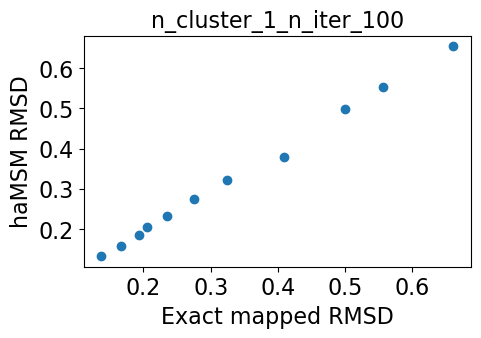

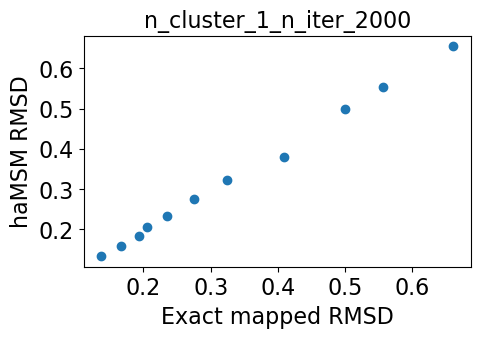

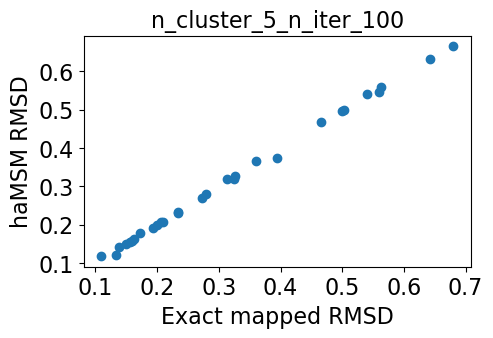

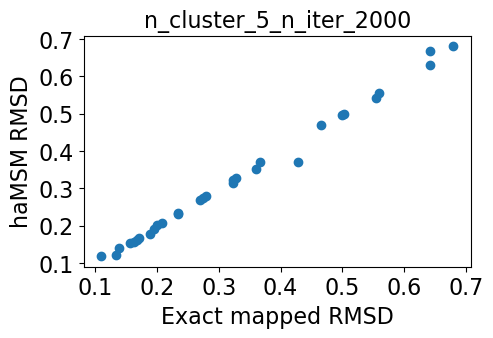

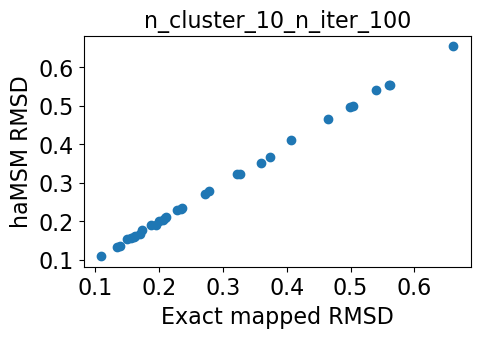

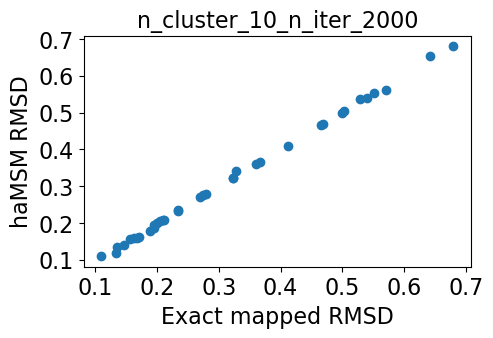

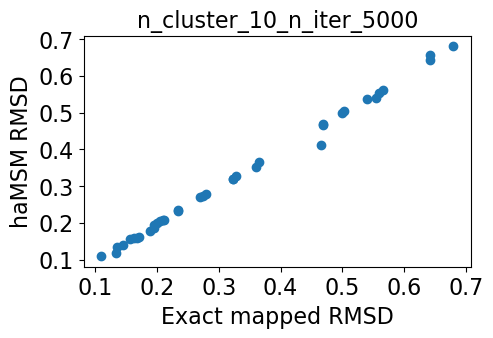

In [34]:
for param in haMSM_params:
    plt.figure(figsize=(5,3))
    plt.scatter(exact_mapped_functions[param]['RMSD'][:-2],haMSM_functions[param]['RMSD'][:-2])

    font = 16
    plt.xticks(size=font);
    plt.yticks(size=font);
    plt.xlabel(f'Exact mapped RMSD',size=font);
    plt.ylabel(f'haMSM RMSD',size=font);
    plt.title(param,size=font)
    plt.show()

Overall we see that the RMSD definitions for two different sets of clusters agree with each other with slight differences that come from calculating new cluster definitions when doing the exact mapped calculations. 

Since doing this analysis I realized that you could calculate the VAMP values of the clusters as well using ```.cluster_structures``` and ```.cluster_structure_weights```, but I didn't think it was necessary since the reasoning for the exact mapped procedure was sound. I also think that it won't make too much of a difference. 

Let's first use the test function to see whether the haMSM functions and exact mapped functions agree with each other. The function ```test_solev_discrepancy``` is from https://github.com/jdrusso/msm_we/blob/main/tests/test_optimization.py. 

In [35]:
def test_solve_discrepancy(completed_model, discrepancy, variance):
    calc_discrepancy, calc_variance = mo.solve_discrepancy(
        tmatrix=completed_model.Tmatrix,
        pi=completed_model.pSS,
        B=completed_model.indTargets,
    )
    assert np.allclose(calc_discrepancy, discrepancy)
    assert np.allclose(calc_variance, variance)

In [36]:
for param in haMSM_params:
    try: 
        test_solve_discrepancy(models[param], exact_mapped_functions[param]['h'], exact_mapped_functions[param]['v'])
    except:
        print(f'Disagreement between haMSM and exact mapped discrepancy for parameter combination {param}')

[09/23/23 16:47:55] INFO     Computing pi matrix                                                 ]8;id=459109;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=374011;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Disagreement between haMSM and exact mapped discrepancy for parameter combination n_cluster_1_n_iter_100


                    INFO     Computing pi matrix                                                 ]8;id=441874;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=895484;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Disagreement between haMSM and exact mapped discrepancy for parameter combination n_cluster_1_n_iter_2000


                    INFO     Computing pi matrix                                                 ]8;id=319823;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=232584;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Disagreement between haMSM and exact mapped discrepancy for parameter combination n_cluster_5_n_iter_100


                    INFO     Computing pi matrix                                                 ]8;id=318254;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=537328;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Disagreement between haMSM and exact mapped discrepancy for parameter combination n_cluster_5_n_iter_2000


                    INFO     Computing pi matrix                                                 ]8;id=748508;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=27920;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Disagreement between haMSM and exact mapped discrepancy for parameter combination n_cluster_10_n_iter_100


                    INFO     Computing pi matrix                                                 ]8;id=188785;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=674143;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Disagreement between haMSM and exact mapped discrepancy for parameter combination n_cluster_10_n_iter_2000


                    INFO     Computing pi matrix                                                 ]8;id=235728;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=979877;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Disagreement between haMSM and exact mapped discrepancy for parameter combination n_cluster_10_n_iter_5000


We see that for all parameter combinations, the test fails. Let's look at the functions visually. 

Define plotting functions to make things easier.

In [37]:
def haMSM_and_exact_mapped_side_by_side(function, param):
    plt.figure(figsize=(5,3))
    plt.scatter(exact_mapped_functions[param]['RMSD'][:-2],exact_mapped_functions[param][function][:-2])
    plt.scatter(haMSM_functions[param]['RMSD'][:-2],haMSM_functions[param][function][:-2])
    
    font = 16
    plt.xticks(size=font);
    plt.yticks(size=font);
    plt.xlabel('RMSD (nm)',size=font);
    plt.ylabel(function,size=font);
    plt.title(param,size=font)
    plt.legend(['Exact Mapped','haMSM'],fontsize=font-2);
    plt.show()

In [38]:
def haMSM_and_exact_mapped_scatter(function, param):
    plt.figure(figsize=(5,3))
    plt.scatter(exact_mapped_functions[param][function][:-2],haMSM_functions[param][function][:-2])

    font = 16
    plt.xticks(size=font);
    plt.yticks(size=font);
    plt.xlabel(f'Exact mapped {function}',size=font);
    plt.ylabel(f'haMSM {function}',size=font);
    plt.title(param,size=font)
    plt.show()

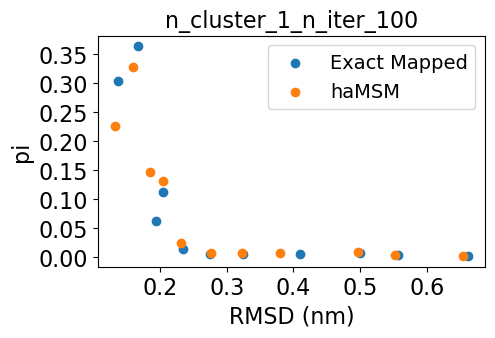

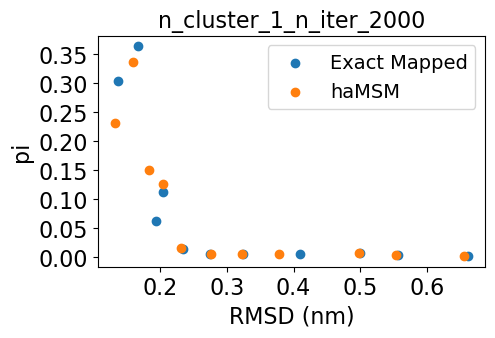

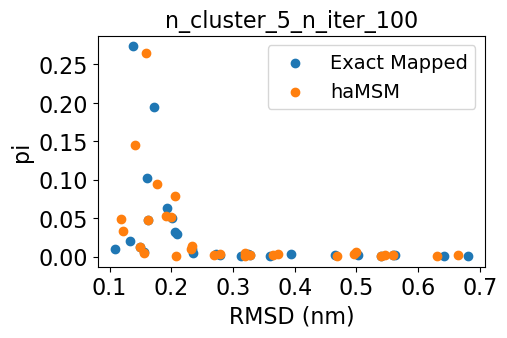

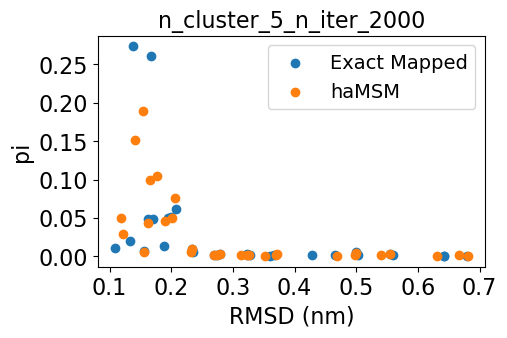

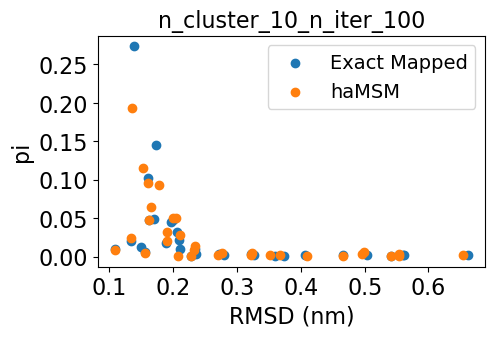

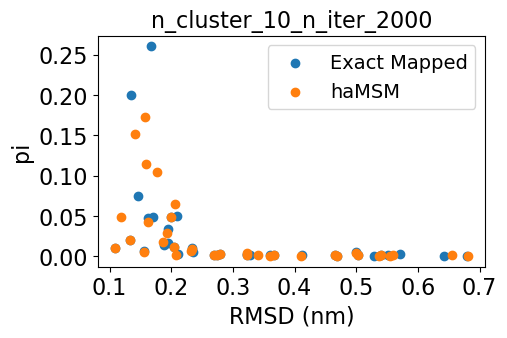

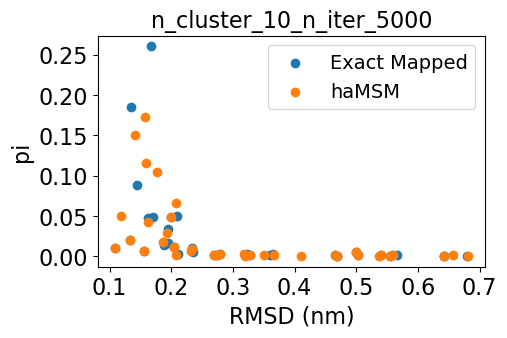

In [39]:
for param in haMSM_params:
    haMSM_and_exact_mapped_side_by_side('pi',param)

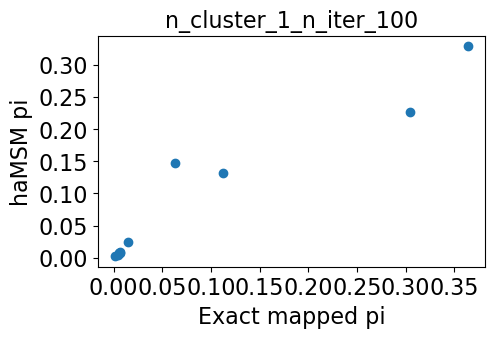

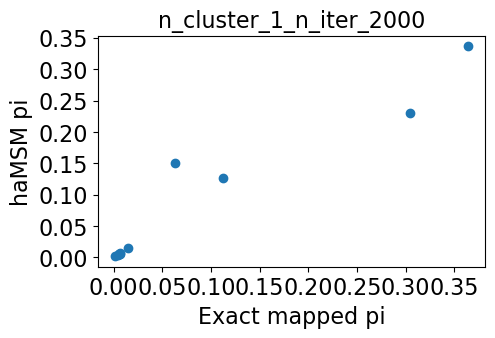

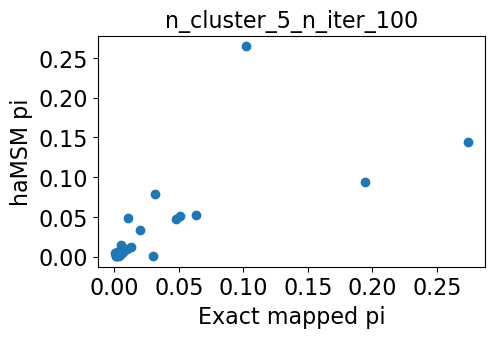

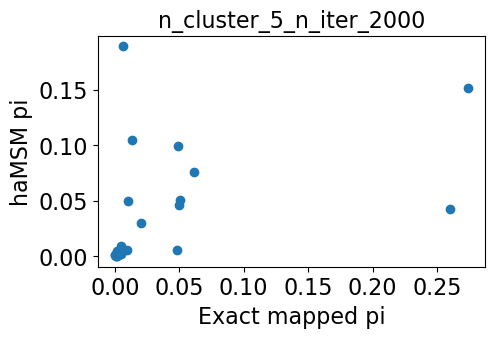

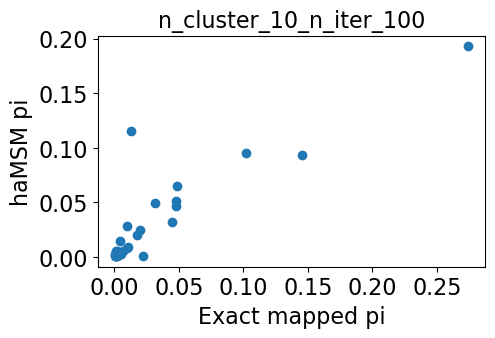

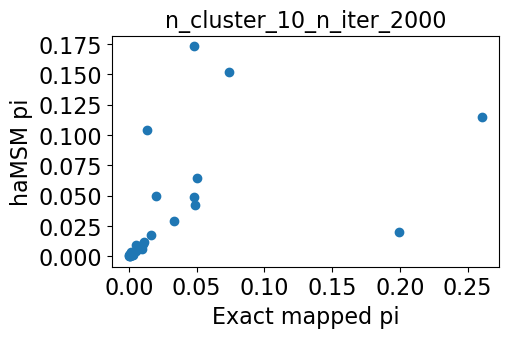

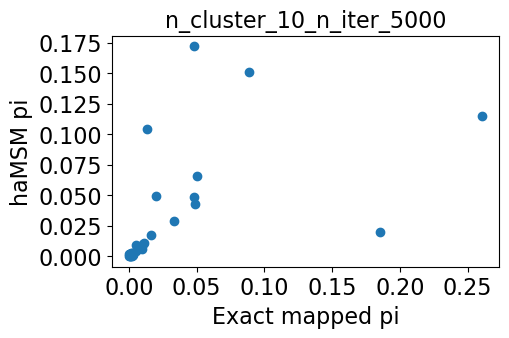

In [40]:
for param in haMSM_params:
    haMSM_and_exact_mapped_scatter('pi',param)

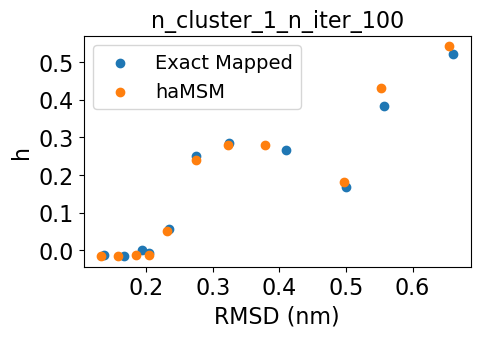

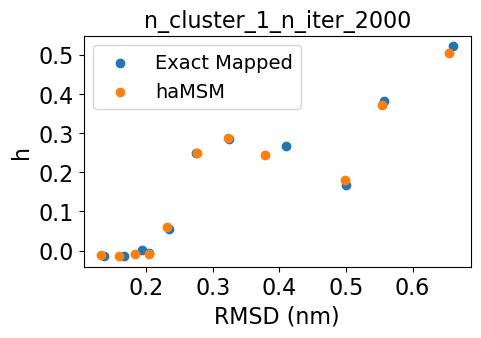

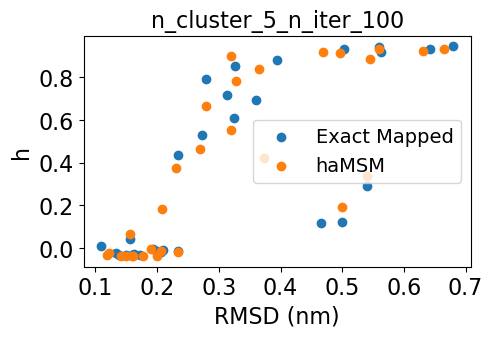

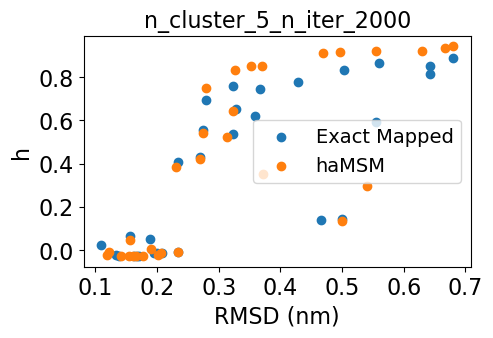

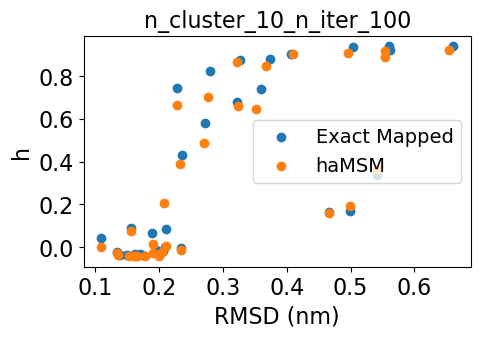

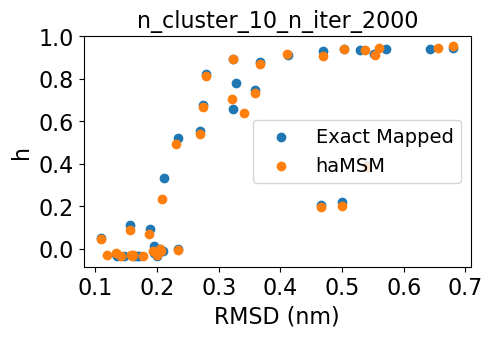

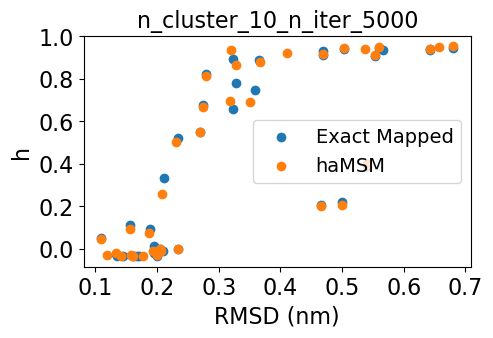

In [41]:
for param in haMSM_params:
    haMSM_and_exact_mapped_side_by_side('h',param)

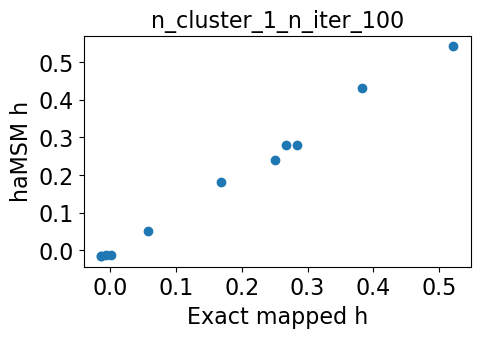

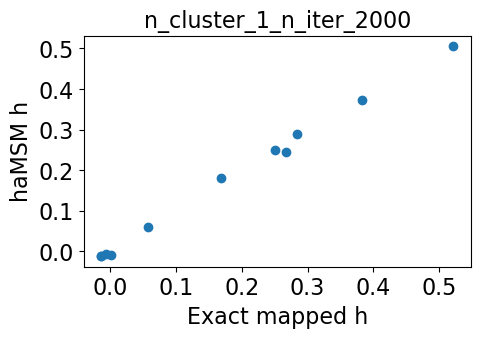

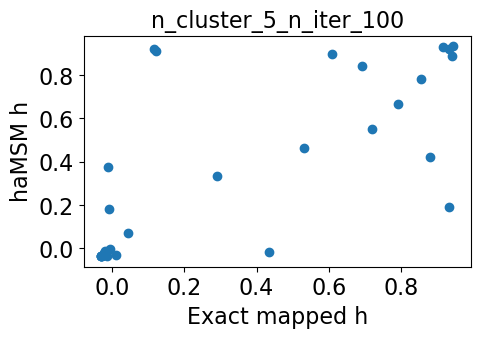

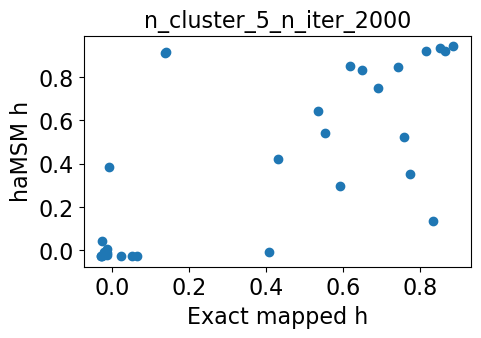

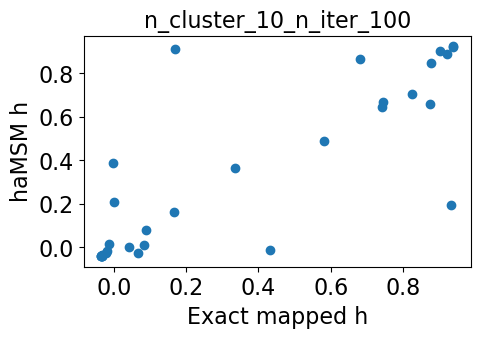

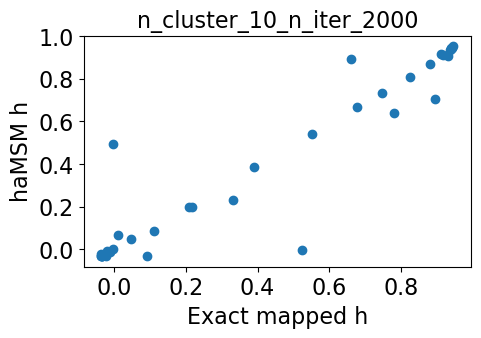

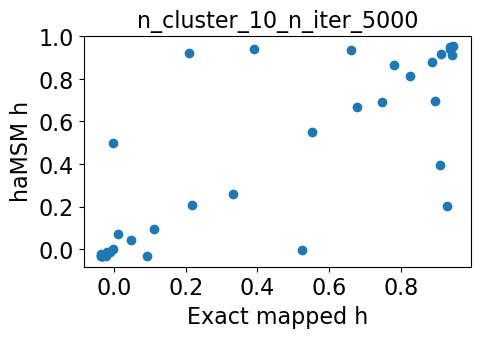

In [42]:
for param in haMSM_params:
    haMSM_and_exact_mapped_scatter('h',param)

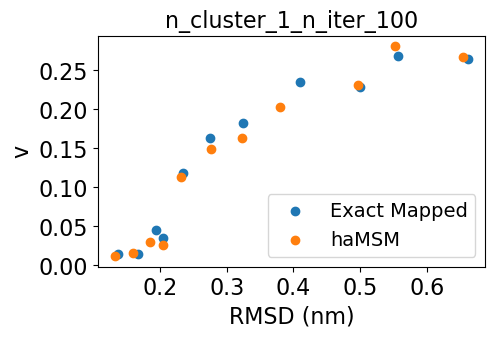

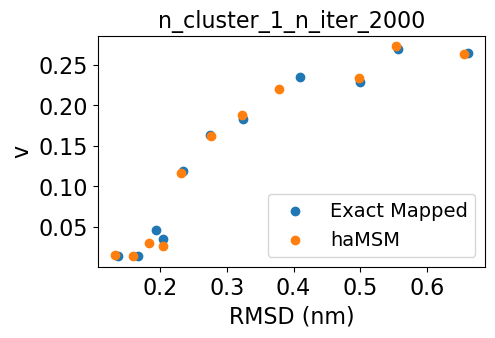

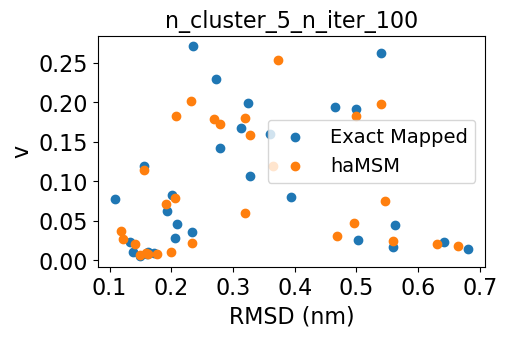

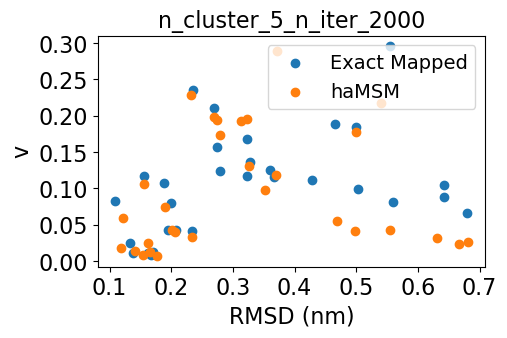

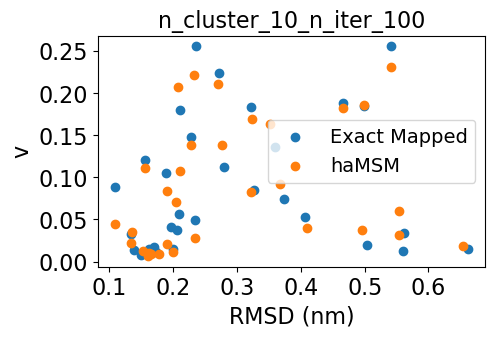

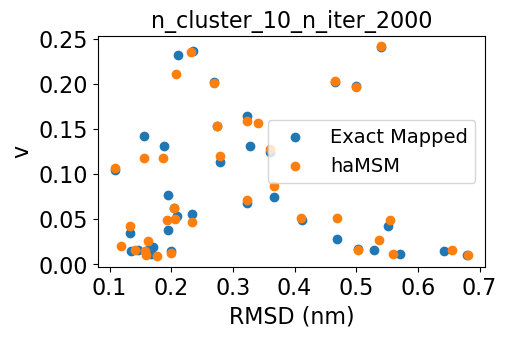

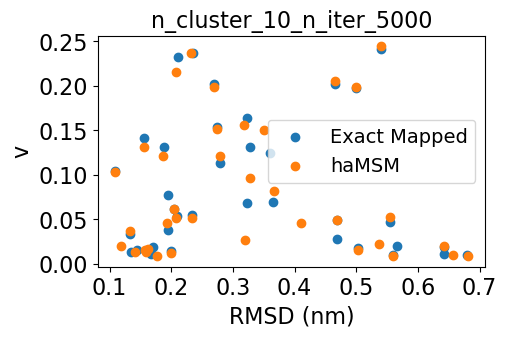

In [43]:
for param in haMSM_params:
    haMSM_and_exact_mapped_side_by_side('v',param)

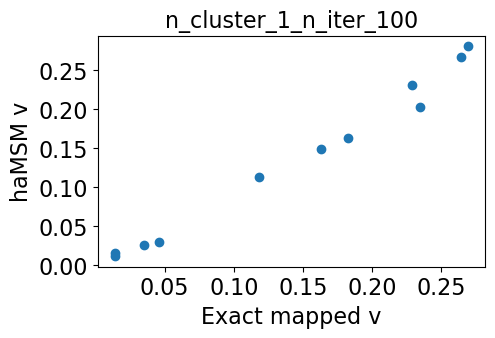

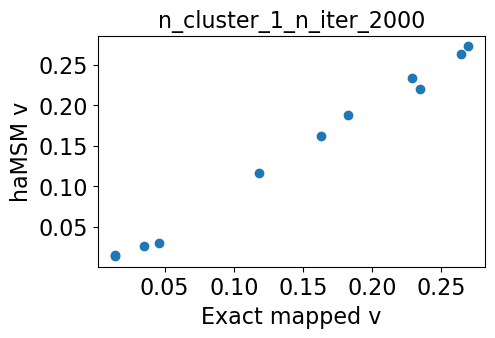

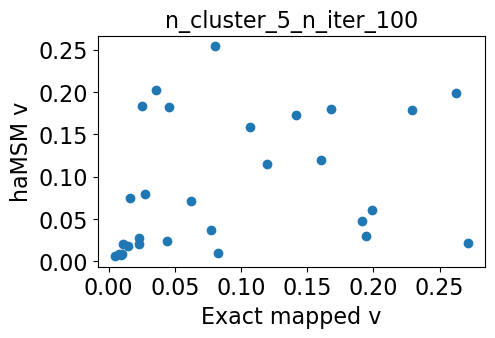

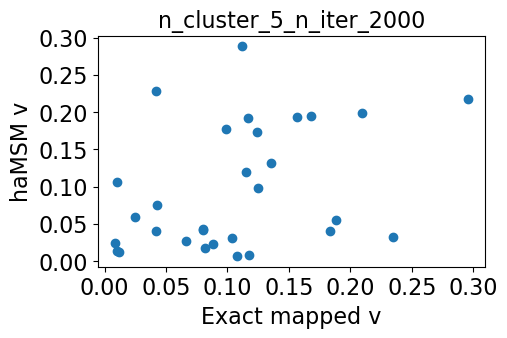

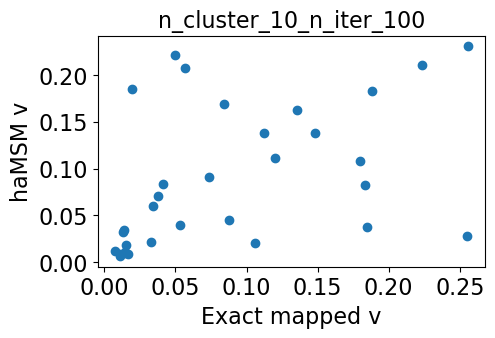

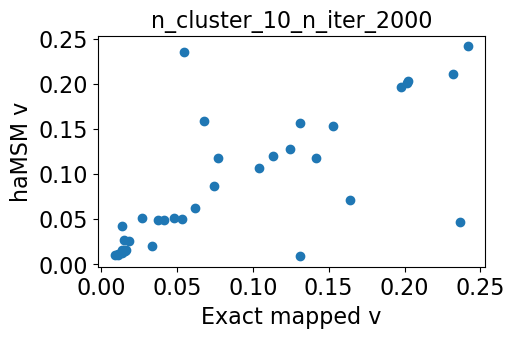

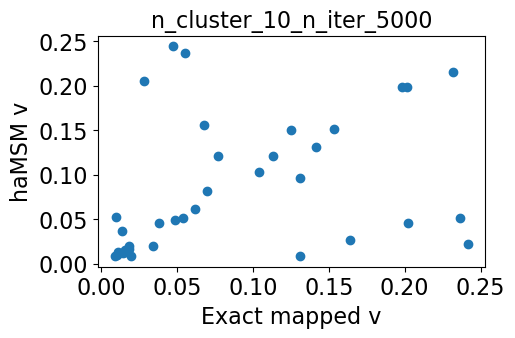

In [44]:
for param in haMSM_params:
    haMSM_and_exact_mapped_scatter('v',param)

Let me focus on the haMSM and exact mapped discrepancy for ```'n_cluster_10_n_iter_2000'```.

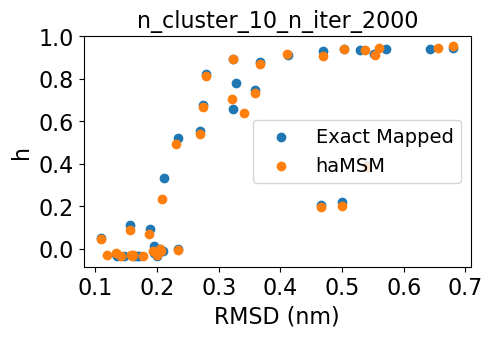

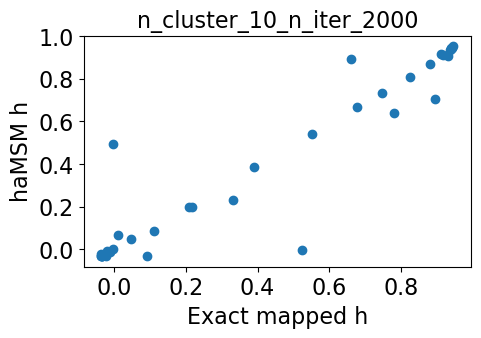

In [45]:
haMSM_and_exact_mapped_side_by_side('h', 'n_cluster_10_n_iter_2000')
haMSM_and_exact_mapped_scatter('h', 'n_cluster_10_n_iter_2000')

One peculiar thing that you see is that when you plot the two side by side, you may think that the agreement between the two is pretty good, given some differences here and there. But in the scatter plot, there are 4 major off-diagonal points. 

The source of this becomes clear when you plot things using line plot instead of scatter plot and change the x axis to cluster index.

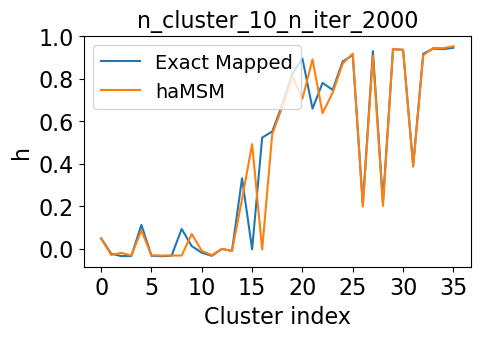

In [46]:
param = 'n_cluster_10_n_iter_2000'
function = 'h'

plt.figure(figsize=(5,3))

n_clusters = len(exact_mapped_functions[param][function])
plt.plot(list(range(n_clusters))[:-2],exact_mapped_functions[param][function][:-2])
plt.plot(list(range(n_clusters))[:-2],haMSM_functions[param][function][:-2])

font = 16
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('Cluster index',size=font);
plt.ylabel(function,size=font);
plt.title(param,size=font)
plt.legend(['Exact Mapped','haMSM'],fontsize=font-2);
plt.show()

Let's zoom into two regions with indices ~15 and ~21.

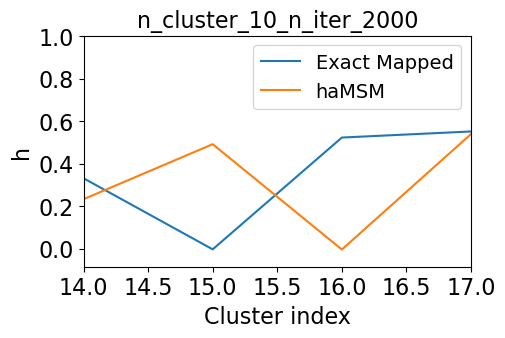

In [47]:
param = 'n_cluster_10_n_iter_2000'
function = 'h'

plt.figure(figsize=(5,3))

n_clusters = len(exact_mapped_functions[param][function])
plt.plot(list(range(n_clusters))[:-2],exact_mapped_functions[param][function][:-2])
plt.plot(list(range(n_clusters))[:-2],haMSM_functions[param][function][:-2])

font = 16
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('Cluster index',size=font);
plt.ylabel(function,size=font);
plt.title(param,size=font)
plt.legend(['Exact Mapped','haMSM'],fontsize=font-2);

plt.xlim([14,17])

plt.show()

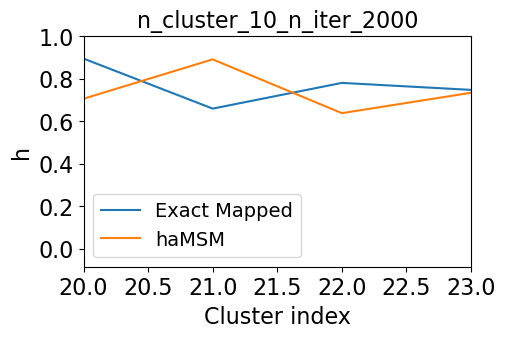

In [48]:
param = 'n_cluster_10_n_iter_2000'
function = 'h'

plt.figure(figsize=(5,3))

n_clusters = len(exact_mapped_functions[param][function])
plt.plot(list(range(n_clusters))[:-2],exact_mapped_functions[param][function][:-2])
plt.plot(list(range(n_clusters))[:-2],haMSM_functions[param][function][:-2])

font = 16
plt.xticks(size=font);
plt.yticks(size=font);
plt.xlabel('Cluster index',size=font);
plt.ylabel(function,size=font);
plt.title(param,size=font)
plt.legend(['Exact Mapped','haMSM'],fontsize=font-2);

plt.xlim([20,23])

plt.show()

These two regions are what was giving the 4 off-diagonal points in the scatter plot. The absolute value of discrepancy that haMSM and exact mapped gives are the same, but they're offset by 1 index, giving off-diagonal points in the scatter plot. 

This is the extent of detail that I have looked into. I'm assuming that these large discrepancy value changes that are offset by single index is giving suboptimal variance minimization results. 

To dig deeper and identify the source of this issue with using haMSM, I've tried looking at ```.cluster_structures``` and ```.cluster_structure_weights``` in the model and compare it with mapping given by exact mapping procedure, but wasn't able to make much out of it. 

I'd appreciate any suggestions or advice on this disagreement between flux results (flux profile + ```JtargetSS```) and actual π, h, and v values compared against exact mapped ones. 

For the remainder of the notebook, I've included some other stuff that I've done that might be relevant to this issue. 

# Appendix 1: Estimating π, h, and v using MSM

Once I was stuck with using haMSM, the immediate thing that I've tried was just using simple MSM to estimate π, h, and v and compare it to exact mapped ones.

Here's the main function to use. 

In [49]:
def MSM_approximated_h_v_pi(
    tmatrix_FG,
    n_steps,
    RMSD, # RMSD of all the microstates
    bin_boundaries, # in WE format
    n_clusters_per_strata, 
    RMSD_threshold = 0.7
):
    # MSM using the underlying FG transition matrix
    model = MarkovStateModel(tmatrix_FG)
    
    # create discrete trajectory for n_steps, conver it to continuous trajectories
    # for now just using RMSD, but can be expanded
    disc_traj = model.simulate(n_steps=n_steps)
    cont_traj = RMSD[disc_traj]
    cont_traj = cont_traj.reshape(-1,1)

    # Define the clusterer
    clusterer = StratifiedClusters(n_clusters=n_clusters_per_strata, bin_bounds=bin_boundaries[1:-1])
    # [1:-1] to remove the 0 and np.inf
    
    # Fit the continuous trajectory and then get cluster assignments of it
    clusterer.fit(cont_traj, coord_to_stratify=0)
    cluster_traj = clusterer.predict(cont_traj)

    # MSM using cluster resolution discrete trajectory
    model_approx = MaximumLikelihoodMSM(reversible=False).fit(cluster_traj, lagtime=1).fetch_model()

    # Get target cluster 
    target_cluster = np.where(clusterer.cluster_centers>RMSD_threshold)[0]

    # Calculate the functions
    pi_approx = model_approx.stationary_distribution
    h_approx, v_approx = mo.solve_discrepancy(model_approx.transition_matrix, pi_approx, target_cluster)

    # Get cluster assignments (mapping) 
    cluster_assignment = clusterer.predict(RMSD.reshape(-1,1))
    
    return pi_approx, h_approx, v_approx, clusterer.cluster_centers, cluster_assignment

This function does only use RMSD as the coordinate, but the idea is same even if you use additional dimensionality reduction methods. 

In [50]:
n_steps = 200000
n_clusters_per_strata = 10
# New bin boundaries
bin_boundaries = [0.        , 0.16001919, 0.19955947, 0.23441049,
       0.28767538, 0.36840332, 0.52846795, 0.7,  np.inf]

pi_approx, h_approx, v_approx, cluster_centers, cluster_assignment = \
MSM_approximated_h_v_pi(
    tmatrix_FG = tmatrix_FG,
    n_steps = n_steps,
    RMSD = state_to_pcoord[:,1], # RMSD of all the microstates
    bin_boundaries = bin_boundaries, # in WE format
    n_clusters_per_strata = n_clusters_per_strata, 
    RMSD_threshold = 0.7
)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[09/23/23 16:48:04] INFO     Computing pi matrix                                                 ]8;id=470539;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=22069;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

  0%|          | 0/8 [00:00<?, ?it/s]

Calculate exact mapped functions (pretty much same procedure as haMSM).

In [51]:
n_cluster = len(cluster_centers)

tmatrix_CG = CG_matrix(n_cluster=n_cluster, 
                       mapping_in_list_form=cluster_assignment, 
                       tmatrix_FG=tmatrix_FG, 
                       pi_exact=pi_exact)

pi_exact_mapped = MarkovStateModel(tmatrix_CG).stationary_distribution
h_exact_mapped, v_exact_mapped = mo.solve_discrepancy(tmatrix_CG,
                                                      pi_exact_mapped,
                                                      np.where(cluster_centers>0.7)[0])

                    INFO     Computing pi matrix                                                 ]8;id=290693;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py\optimization.py]8;;\:]8;id=987965;file:///Users/WHR/opt/anaconda3/envs/hamsm_env/lib/python3.10/site-packages/msm_we/optimization.py#49\49]8;;\

Note that how we calculate the exact mapped functions for haMSM and MSM are slightly different. 

In haMSM:
- We use the strata definition and number of clusters in each strata from haMSM, but perform stratified clustering from scratch.

In MSM:
- The mapping from microstate to cluster is calculated when I'm calculating approximate π, h, and v. The exact mapped functions are calculated using this mapping, FG transition matrix, and FG steady state. 

Let's comapre the functions.

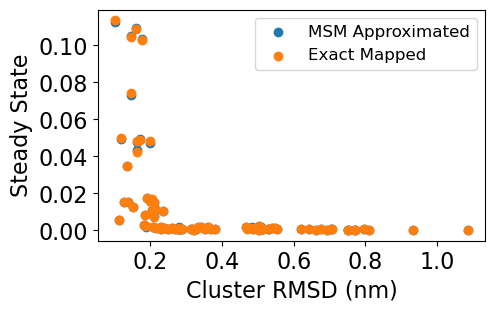

In [52]:
plt.figure(figsize=(5,3))

plt.scatter(cluster_centers, pi_approx)
plt.scatter(cluster_centers, pi_exact_mapped)

font=16
plt.xlabel('Cluster RMSD (nm)',size=font);
plt.ylabel('Steady State',size=font);
plt.xticks(size=font);
plt.yticks(size=font);

label = ['MSM Approximated','Exact Mapped'];
plt.legend(label,fontsize=font-4);

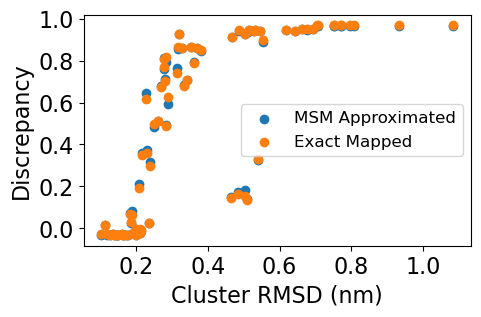

In [53]:
plt.figure(figsize=(5,3))

plt.scatter(cluster_centers, h_approx)
plt.scatter(cluster_centers, h_exact_mapped)

font=16
plt.xlabel('Cluster RMSD (nm)',size=font);
plt.ylabel('Discrepancy',size=font);
plt.xticks(size=font);
plt.yticks(size=font);

label = ['MSM Approximated','Exact Mapped'];
plt.legend(label,fontsize=font-4);

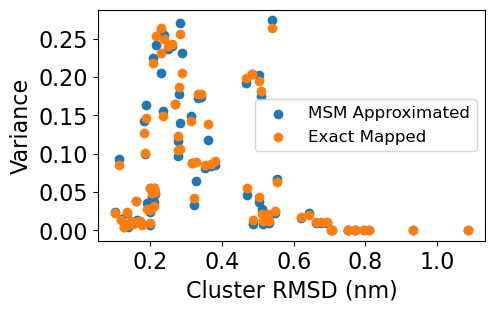

In [54]:
plt.figure(figsize=(5,3))

plt.scatter(cluster_centers, v_approx)
plt.scatter(cluster_centers, v_exact_mapped)

font=16
plt.xlabel('Cluster RMSD (nm)',size=font);
plt.ylabel('Variance',size=font);
plt.xticks(size=font);
plt.yticks(size=font);

label = ['MSM Approximated','Exact Mapped'];
plt.legend(label,fontsize=font-4);

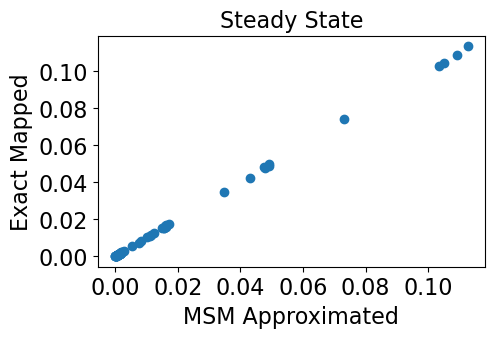

In [55]:
plt.figure(figsize=(5,3))

plt.scatter(pi_approx, pi_exact_mapped)

font=16
plt.xlabel('MSM Approximated',size=font);
plt.ylabel('Exact Mapped',size=font);
plt.xticks(size=font);
plt.yticks(size=font);

plt.title('Steady State',size=font);

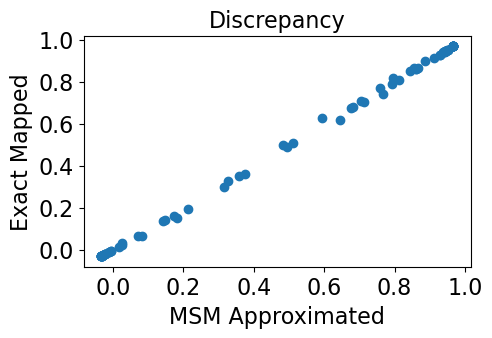

In [56]:
plt.figure(figsize=(5,3))

plt.scatter(h_approx, h_exact_mapped)

font=16
plt.xlabel('MSM Approximated',size=font);
plt.ylabel('Exact Mapped',size=font);
plt.xticks(size=font);
plt.yticks(size=font);

plt.title('Discrepancy',size=font);

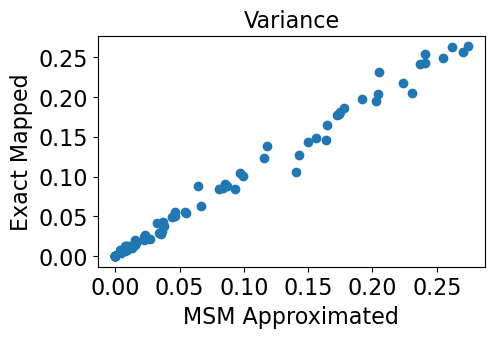

In [57]:
plt.figure(figsize=(5,3))

plt.scatter(v_approx, v_exact_mapped)

font=16
plt.xlabel('MSM Approximated',size=font);
plt.ylabel('Exact Mapped',size=font);
plt.xticks(size=font);
plt.yticks(size=font);

plt.title('Variance',size=font);

Roughly speaking, the 200000 steps of synD trajectory is propoortional to 1000 iterations of WE with 13 bins and 8 walkers per bin (12 non-target bins * 8 walkers = 96 walkers throughout the simulation). And for the scatter plot between the MSM approximated and exact mapped, we see pretty good and linear agreement between the two cases. 

I understand that this isn't quite apples to apples to the haMSM analysis, but I think it should give us a sense of how much sampling is needed to get a decent approximation of the transition matrix and the functions. 

# Appendix 2: Degeneracy of states in haMSM mapping? 

Here, I'm going to show that when you extract unique microstates and their weights from ```.cluster_structures``` and ```.cluster_structure_weights```, the source microstate seems to be mapped to multiple clusters. I'm not sure whether that's part of the design or some error, but here's the code to show it. 

From my understanding, ```.cluster_structures[i]``` and ```.cluster_structure_weights[i]``` of the model contains atomic configurations of each microstate (may contain duplicates) and their weights that have been mapped to the ith cluster. 

In [58]:
for i in range(len(models['n_cluster_1_n_iter_100'].targetRMSD_centers)):
    print(f'Cluster {i} contains {np.shape(models["n_cluster_1_n_iter_100"].cluster_structures[i])[0]} microstates')

Cluster 0 contains 994 microstates
Cluster 1 contains 1384 microstates
Cluster 2 contains 780 microstates
Cluster 3 contains 725 microstates
Cluster 4 contains 559 microstates
Cluster 5 contains 615 microstates
Cluster 6 contains 643 microstates
Cluster 7 contains 640 microstates
Cluster 8 contains 606 microstates
Cluster 9 contains 614 microstates
Cluster 10 contains 468 microstates
Cluster 11 contains 409 microstates
Cluster 12 contains 403 microstates


What I want to do is see the index of unique mapped microstates and their corresponding weights. The function shown below does that. 

In [59]:
def find_discrete_state(value, coord_map):
    """
    Finds the key associated with a given value in a coordinate mapping.

    Parameters:
        value (numpy.ndarray): The value to search for in the coordinate mapping.
        coord_map (dict): A dictionary mapping keys to coordinate values.

    Returns:
        object: The key associated with the given value, or None if the value is not found.
    """

    for key, val in coord_map.items():
        if np.array_equal(val, value):
            return key
    return None

In [60]:
def get_discrete_mapping_full(model, coord_map):
    """
    Convert AA structure stored in model.cluster_structures to discrete microstate index using coord_map.
    
    This function takes a structural model and a mapping of coordinates to discrete states and
    converts the atomic structure stored in the model's cluster structures into a representation
    of discrete microstate indices based on the provided coordinate map.
    
    Args:
    model (object): A model containing cluster structures and related information.
    coord_map (dict): A dictionary that maps specific coordinates to discrete state indices.
    
    Returns:
    tuple: A tuple containing two dictionaries.
        - The first dictionary (mapped_microstates) maps cluster indices to arrays of discrete microstate indices.
        - The second dictionary (mapped_microstates_weights) maps cluster indices to arrays of weights.
    """
    # Get the number of clusters
    n_cluster = len(model.targetRMSD_centers)
    
    # Initialize dictionaries to store mapped microstates and their weights
    mapped_microstates = {}
    mapped_microstates_weights = {}
    
    for i in range(n_cluster):
        # Array that will be the value for key i
        mapped_microstates_bin_i = np.zeros(np.shape(model.cluster_structures[i])[0], dtype='int32')
    
        # Convert the full atomic structure into microstate index
        for j, structure in enumerate(model.cluster_structures[i]):
            mapped_microstates_bin_i[j] = find_discrete_state(structure, coord_map)
    
        mapped_microstates[i] = mapped_microstates_bin_i
        mapped_microstates_weights[i] = np.array(model.cluster_structure_weights[i])

    return mapped_microstates, mapped_microstates_weights

In [61]:
def get_discrete_mapping_unique(mapped_microstates, mapped_microstates_weights):
    """
    Get unique microstate representations and corresponding weights from given mapped microstates and weights.
    
    This function takes dictionaries of mapped microstates and their associated weights, and computes unique
    microstate representations and normalized weights for each cluster index.
    
    Args:
    mapped_microstates (dict): A dictionary where keys are cluster indices and values are arrays of mapped microstate indices.
    mapped_microstates_weights (dict): A dictionary where keys are cluster indices and values are arrays of microstate weights.
    
    Returns:
    tuple: A tuple containing two dictionaries.
        - The first dictionary (mapped_microstates_unique) maps cluster indices to arrays of unique microstate indices.
        - The second dictionary (mapped_microstates_weights_unique) maps cluster indices to arrays of normalized microstate weights.
    """
    # Get the number of clusters
    n_cluster = len(mapped_microstates)

    # Initialize dictionaries to store unique microstates and their weights
    mapped_microstates_unique = {}
    mapped_microstates_weights_unique = {}
    
    for key, item in mapped_microstates.items():
        # Unique microstates and respective weights 
        unique_microstate = np.unique(item)
        unique_microstate_weights = np.zeros_like(unique_microstate, dtype='float32')
        
        # Loop through unique_microstate to compute the aggregated microstate weights
        for index, value in enumerate(unique_microstate): 
            unique_microstate_weights[index] = np.sum(mapped_microstates_weights[key][np.where(item == value)])

        # Normalize microstate weights and assign
        normalized_weights = unique_microstate_weights / np.sum(unique_microstate_weights)
        mapped_microstates_unique[key] = unique_microstate
        mapped_microstates_weights_unique[key] = normalized_weights
    
    return mapped_microstates_unique, mapped_microstates_weights_unique

We get two dictionaries:
- ```mapped_microstates_hamsm```: cluster index as key, mapped microstate indices as values
- ```mapped_microstates_weights_hamsm```: cluster index as key, weight of mapped microstate indices (same as in ```mapped_microstates_hamsm```) as values 

In [62]:
mapped_full, mapped_weights_full = get_discrete_mapping_full(models['n_cluster_1_n_iter_100'], coord_map)
mapped_microstates_hamsm, mapped_microstates_weights_hamsm = get_discrete_mapping_unique(mapped_full, mapped_weights_full)

Let's look at the ```mapped_microstates_hamsm```.

In [63]:
mapped_microstates_hamsm

{0: array([ 0,  1,  2,  5,  7, 10, 14, 24, 25], dtype=int32),
 1: array([ 3,  4,  6,  7,  9, 11, 12, 29, 31], dtype=int32),
 2: array([ 7,  8, 16, 19, 26, 27, 28, 30, 32], dtype=int32),
 3: array([13, 15, 17, 18, 20, 21, 23, 37], dtype=int32),
 4: array([22, 38, 40, 41, 42, 44, 45, 53], dtype=int32),
 5: array([43, 46, 47, 51, 56, 57, 59, 60], dtype=int32),
 6: array([48, 50, 54, 55, 58, 62, 64, 72], dtype=int32),
 7: array([34, 49, 52, 61, 63, 65, 66, 71], dtype=int32),
 8: array([33, 35, 36, 68, 73, 77, 81, 84], dtype=int32),
 9: array([39, 67, 74, 78, 80, 83, 85, 88], dtype=int32),
 10: array([75, 79, 82, 87, 89, 90], dtype=int32),
 11: array([7], dtype=int32),
 12: array([69, 70, 76, 86, 91, 92, 93, 94, 95, 96, 97], dtype=int32)}

In the microstate resolution, 7 is the source microstate index. And it makes sense that the microstate 7 is mapped to ```n_cluster-2```th cluster (11), which by convention corresponds to the basis cluster. However, it seems that the microstate 7 is also mapped to cluster 0, 1, and 2. 

Is this by design that I'm not aware of? or is it some type of error? 